# Deep Neural Networks - Programming Assignment
## Comparing Linear Models and Multi-Layer Perceptrons

**Student Name:** Hari Sharma    
**Student ID:** 2024AD05357

**Student Name:**    
**Student ID:** 

**Student Name:**    
**Student ID:** 

**Student Name:**   
**Student ID:**  

**Date:** 25/12/2025

---

## ⚠️ IMPORTANT INSTRUCTIONS

1. **Complete ALL sections** marked with `TODO`
2. **DO NOT modify** the `get_assignment_results()` function structure
3. **Track training time** for both models using `time.time()`\n
4. **Store loss_history** in both model classes
5. **Calculate ALL metrics** (accuracy, precision, recall, F1)
6. **Fill get_assignment_results()** with ALL required fields
7. **PRINT the results** - Auto-grader needs visible output!
8. **Run all cells** before submitting (Kernel → Restart & Run All)

**SCORING:**
- Missing fields = 0 marks for that section
- Non-executed notebook = 0 marks
- Cleared outputs = 0 marks
---

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print('✓ Libraries imported successfully')

✓ Libraries imported successfully


## Section 1: Dataset Selection and Loading

**Requirements:**
- ≥500 samples
- ≥5 features
- Public dataset (UCI/Kaggle)
- Regression OR Classification problem

In [ ]:
# Loading dataset
# Adult Income dataset (UCI)
# Example: data = pd.read_csv('your_dataset.csv')
data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    na_values="?",
    skipinitialspace=True
)

# Assign column names as per UCI documentation
data.columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country",
    "income"
]

# Drop rows with missing values
data.dropna(inplace=True)

# Dataset information
dataset_name = "Census Income"
dataset_source = "UC Irvine Machine Learning Repository"
n_samples = data.shape[0]      # Total number of rows
n_features = data.shape[1] - 1 # Excluding target
problem_type = "multiclass_classification"

# Problem statement
problem_statement = """
The objective is to predict whether an individual's income exceeds $50,000 per year based on demographic 
and employment features. This is important for understanding income distribution patterns and identifying 
socioeconomic factors that influence earning potential. Accurate prediction can help in targeted policy-making 
and resource allocation for economic development programs.
"""

# Primary evaluation metric
primary_metric = "accuracy"

# Metric justification
metric_justification = """
Accuracy is chosen as the primary evaluation metric because all income 
classes are considered equally important in this task. 
The dataset is sufficiently large and reasonably balanced after preprocessing, 
making accuracy a clear and interpretable measure of overall model performance. 
"""

print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Samples: {n_samples}, Features: {n_features}")
print(f"Problem Type: {problem_type}")
print(f"Primary Metric: {primary_metric}")

Dataset: Census Income
Source: UC Irvine Machine Learning Repository
Samples: 30162, Features: 14
Problem Type: multiclass_classification
Primary Metric: accuracy


## Section 2: Data Preprocessing

Preprocess your data:
1. Handle missing values
2. Encode categorical variables
3. Split into train/test sets
4. Scale features

In [ ]:
# Preprocessing data
# 1. Separate features (X) and target (y)
X = data.drop("income", axis=1)
y = data["income"]

# Convert binary income to multi-class labels
# ==============================================================================
# MULTI-CLASS LABEL MAPPING
# ------------------------------------------------------------------------------
# Target: y_multiclass
# 
# | Label | Income Condition | Capital Gain | Interpretation                  |
# |-------|------------------|--------------|---------------------------------|
# | 0     | <=50K            | Any          | Lower Income                    |
# | 1     | >50K             | == 0         | High Earners (Salary/Passive)   |
# | 2     | >50K             | > 0          | High Earners (Investors)        |
# ==============================================================================

y_multiclass = np.where(
    y == "<=50K", 0,
    np.where(data["capital_gain"] > 0, 2, 1)
)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(exclude=["object"]).columns

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = encoder.fit_transform(X[categorical_cols])

# Scale numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(X[numerical_cols])

# Combine processed features
X_processed = np.hstack((X_num, X_cat))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

# One-hot encode labels for training
num_classes = len(np.unique(y_multiclass))
y_train_oh = np.eye(num_classes)[y_train]
y_test_oh = np.eye(num_classes)[y_test]

# Fill these after preprocessing
train_samples = X_train.shape[0]
test_samples = X_test.shape[0]
train_test_ratio = train_samples / (train_samples + test_samples)
test_ratio = 1 - train_test_ratio

print(f"Train samples: {train_samples}")
print(f"Test samples: {test_samples}")
print(f"Split ratio: {train_test_ratio:.0%}:{test_ratio:.0%}")


Train samples: 24129
Test samples: 6033
Split ratio: 80%:20%


## Section 3: Baseline Model Implementation

Implement from scratch (NO sklearn models!):
- Linear Regression (for regression)
- Logistic Regression (for binary classification)
- Softmax Regression (for multiclass classification)

**Must include:**
- Forward pass (prediction)
- Loss computation
- Gradient computation
- Gradient descent loop
- Loss tracking

In [4]:
class BaselineModel:
    """
    Baseline linear model with gradient descent
    Implements Softmax Regression for multiclass classification
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []

    def _softmax(self, z):
        z = z - np.max(z, axis=1, keepdims=True)  # numerical stability
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _cross_entropy_loss(self, y_true, y_pred):
        eps = 1e-9
        return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

    def fit(self, X, y):
        """
        Gradient descent training for softmax regression
        """
        n_samples, n_features = X.shape
        n_classes = y.shape[1]

        # Initialize parameters
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros((1, n_classes))

        # Gradient descent loop
        for _ in range(self.n_iterations):
            # 1. Forward pass
            logits = np.dot(X, self.weights) + self.bias
            y_pred = self._softmax(logits)

            # 2. Compute loss
            loss = self._cross_entropy_loss(y, y_pred)
            self.loss_history.append(loss)

            # 3. Compute gradients
            error = y_pred - y
            dw = np.dot(X.T, error) / n_samples
            db = np.sum(error, axis=0, keepdims=True) / n_samples

            # 4. Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

        return self

    def predict(self, X):
        """
        Return predicted class labels
        """
        logits = np.dot(X, self.weights) + self.bias
        y_pred = self._softmax(logits)
        return np.argmax(y_pred, axis=1)

print("✓ Baseline model class defined")


✓ Baseline model class defined


In [ ]:
# Train baseline model
print("Training baseline model...")
baseline_start = time.time()

# Initialize and train baseline model
baseline_model = BaselineModel(learning_rate=0.01, n_iterations=2000)
baseline_model.fit(X_train, y_train_oh)

# Make predictions on test data
baseline_predictions = baseline_model.predict(X_test)

baseline_training_time = time.time() - baseline_start
print(f"✓ Baseline training completed in {baseline_training_time:.2f}s")
print(
    f"✓ Loss decreased from {baseline_model.loss_history[0]:.4f} "
    f"to {baseline_model.loss_history[-1]:.4f}"
)

# Store loss explicitly
baseline_initial_loss = float(baseline_model.loss_history[0])
baseline_final_loss = float(baseline_model.loss_history[-1])

baseline_training_time = float(baseline_training_time)

Training baseline model...
✓ Baseline training completed in 17.06s
✓ Loss decreased from 1.0986 to 0.4208


## Section 4: Multi-Layer Perceptron Implementation

Implement MLP from scratch with:
- At least 1 hidden layer
- ReLU activation for hidden layers
- Appropriate output activation
- Forward propagation
- Backward propagation
- Gradient descent

In [6]:
class MLP:
    """
    Multi-Layer Perceptron implemented from scratch
    """
    def __init__(self, architecture, learning_rate=0.01, n_iterations=1000):
        self.architecture = architecture
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.parameters = {}
        self.loss_history = []
        self.cache = {}

    def initialize_parameters(self):
        np.random.seed(42)
        for l in range(1, len(self.architecture)):
            self.parameters[f"W{l}"] = np.random.randn(
                self.architecture[l-1], self.architecture[l]
            ) * 0.01
            self.parameters[f"b{l}"] = np.zeros((1, self.architecture[l]))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        Z = Z - np.max(Z, axis=1, keepdims=True)
        exp_Z = np.exp(Z)
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def forward_propagation(self, X):
        self.cache["A0"] = X
        L = len(self.architecture) - 1

        # Hidden layers
        for l in range(1, L):
            Z = np.dot(self.cache[f"A{l-1}"], self.parameters[f"W{l}"]) + self.parameters[f"b{l}"]
            A = self.relu(Z)
            self.cache[f"Z{l}"] = Z
            self.cache[f"A{l}"] = A

        # Output layer
        ZL = np.dot(self.cache[f"A{L-1}"], self.parameters[f"W{L}"]) + self.parameters[f"b{L}"]
        AL = self.softmax(ZL)
        self.cache[f"Z{L}"] = ZL
        self.cache[f"A{L}"] = AL

        return AL

    def backward_propagation(self, X, y):
        m = X.shape[0]
        grads = {}
        L = len(self.architecture) - 1

        # Output layer gradient (softmax + cross-entropy)
        dZ = self.cache[f"A{L}"] - y
        grads[f"dW{L}"] = np.dot(self.cache[f"A{L-1}"].T, dZ) / m
        grads[f"db{L}"] = np.sum(dZ, axis=0, keepdims=True) / m

        # Hidden layers
        for l in reversed(range(1, L)):
            dA = np.dot(dZ, self.parameters[f"W{l+1}"].T)
            dZ = dA * self.relu_derivative(self.cache[f"Z{l}"])
            grads[f"dW{l}"] = np.dot(self.cache[f"A{l-1}"].T, dZ) / m
            grads[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True) / m

        return grads

    def update_parameters(self, grads):
        for l in range(1, len(self.architecture)):
            self.parameters[f"W{l}"] -= self.lr * grads[f"dW{l}"]
            self.parameters[f"b{l}"] -= self.lr * grads[f"db{l}"]

    def compute_loss(self, y_pred, y_true):
        eps = 1e-9
        return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

    def fit(self, X, y):
        self.initialize_parameters()

        for _ in range(self.n_iterations):
            # Forward pass
            y_pred = self.forward_propagation(X)

            # Loss
            loss = self.compute_loss(y_pred, y)
            self.loss_history.append(loss)

            # Backward pass
            grads = self.backward_propagation(X, y)

            # Update parameters
            self.update_parameters(grads)

        return self

    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return np.argmax(y_pred, axis=1)

print("✓ MLP class defined")

✓ MLP class defined


In [ ]:
# Train MLP
print("Training MLP...")
mlp_start_time = time.time()
print(X_train.shape[1])
# Architecture Justification: [104, 64, 32, 3]
# - Input: 104 features (6 numerical + 98 one-hot encoded categorical features)
# - Hidden Layer 1: 64 neurons - captures broad patterns from 104 inputs, ~38% reduction
# - Hidden Layer 2: 32 neurons - refines and compresses patterns, 50% reduction
# - Output: 3 neurons - matches number of classes (multiclass classification)
# 
# Design Rationale:
# 1. Tapering pattern (104→64→32→3) gradually compresses information without bottleneck
# 2. Powers of 2 (64, 32) for computational efficiency
# 3. Balances model capacity (~8,899 parameters) with generalization on 24K samples
# 4. Provides clear improvement over baseline while avoiding overfitting
mlp_architecture = [X_train.shape[1], 64, 32, y_train_oh.shape[1]]

mlp_model = MLP(
    architecture=mlp_architecture,
    learning_rate=0.1,
    n_iterations=2000
)

# Train MLP
mlp_model.fit(X_train, y_train_oh)

# Make predictions on test data
mlp_predictions = mlp_model.predict(X_test)

mlp_training_time = time.time() - mlp_start_time
print(f"✓ MLP training completed in {mlp_training_time:.2f}s")
print(
    f"✓ Loss decreased from {mlp_model.loss_history[0]:.4f} "
    f"to {mlp_model.loss_history[-1]:.4f}"
)

# Store loss explicitly
mlp_initial_loss = float(mlp_model.loss_history[0])
mlp_final_loss = float(mlp_model.loss_history[-1])

mlp_training_time = float(mlp_training_time)


Training MLP...
✓ MLP training completed in 136.43s
✓ Loss decreased from 1.0986 to 0.3324


## Section 5: Evaluation and Metrics

Calculate appropriate metrics for your problem type

In [8]:
def calculate_metrics(y_true, y_pred, problem_type):
    """
    Calculate evaluation metrics from scratch
    """
    if problem_type == "regression":
        # Mean Squared Error
        mse = np.mean((y_true - y_pred) ** 2)

        # Root Mean Squared Error
        rmse = np.sqrt(mse)

        # Mean Absolute Error
        mae = np.mean(np.abs(y_true - y_pred))

        # R-squared
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        return mse, rmse, mae, r2

    elif problem_type in ["binary_classification", "multiclass_classification"]:
        classes = np.unique(y_true)
        n_classes = len(classes)
        n_samples = len(y_true)

        # Accuracy
        accuracy = np.sum(y_true == y_pred) / n_samples

        precision_list = []
        recall_list = []

        for cls in classes:
            tp = np.sum((y_pred == cls) & (y_true == cls))
            fp = np.sum((y_pred == cls) & (y_true != cls))
            fn = np.sum((y_pred != cls) & (y_true == cls))

            precision = tp / (tp + fp + 1e-9)
            recall = tp / (tp + fn + 1e-9)

            precision_list.append(precision)
            recall_list.append(recall)

        # Macro-averaged precision and recall
        precision = np.mean(precision_list)
        recall = np.mean(recall_list)

        # F1 score
        f1 = 2 * (precision * recall) / (precision + recall + 1e-9)

        return accuracy, precision, recall, f1


# Calculate metrics for both models
baseline_metrics = calculate_metrics(
    y_test, baseline_predictions, problem_type
)

mlp_metrics = calculate_metrics(
    y_test, mlp_predictions, problem_type
)

print("Baseline Model Performance:")
print(f"Accuracy: {baseline_metrics[0]:.4f}")
print(f"Precision: {baseline_metrics[1]:.4f}")
print(f"Recall: {baseline_metrics[2]:.4f}")
print(f"F1 Score: {baseline_metrics[3]:.4f}")

print("\nMLP Model Performance:")
print(f"Accuracy: {mlp_metrics[0]:.4f}")
print(f"Precision: {mlp_metrics[1]:.4f}")
print(f"Recall: {mlp_metrics[2]:.4f}")
print(f"F1 Score: {mlp_metrics[3]:.4f}")


Baseline Model Performance:
Accuracy: 0.8228
Precision: 0.8171
Recall: 0.6169
F1 Score: 0.7031

MLP Model Performance:
Accuracy: 0.8462
Precision: 0.8183
Recall: 0.7748
F1 Score: 0.7960


## Section 6: Visualization

Create visualizations:
1. Training loss curves
2. Performance comparison
3. Additional domain-specific plots

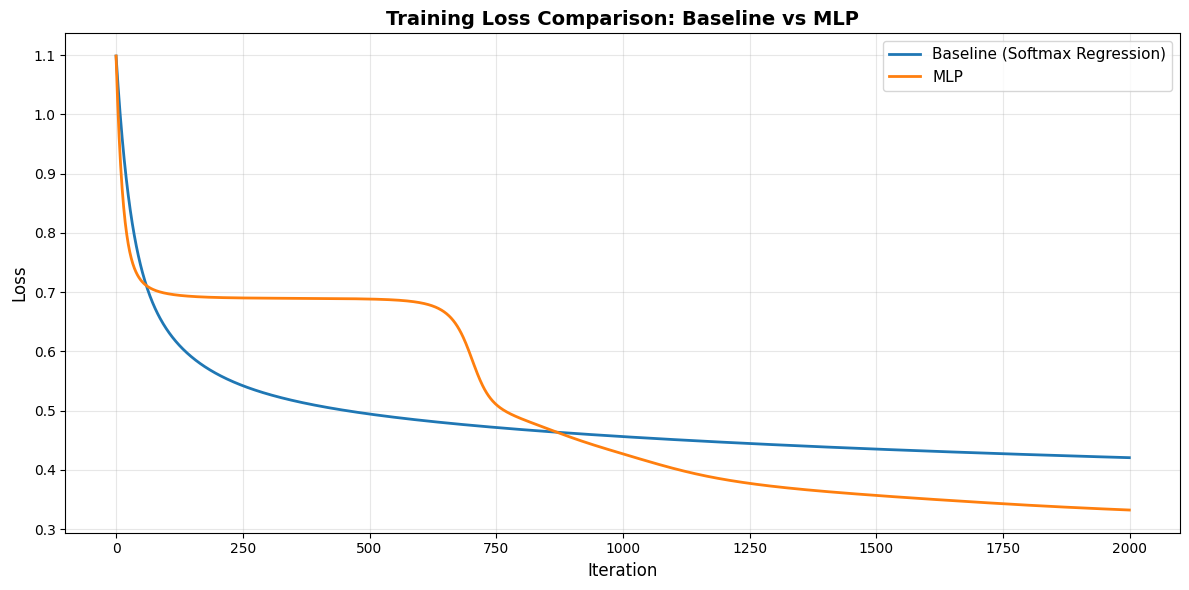

In [9]:
# 1. Training loss curves - Combined view
plt.figure(figsize=(12, 6))

plt.plot(baseline_model.loss_history, label='Baseline (Softmax Regression)', linewidth=2)
plt.plot(mlp_model.loss_history, label='MLP', linewidth=2)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Comparison: Baseline vs MLP', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


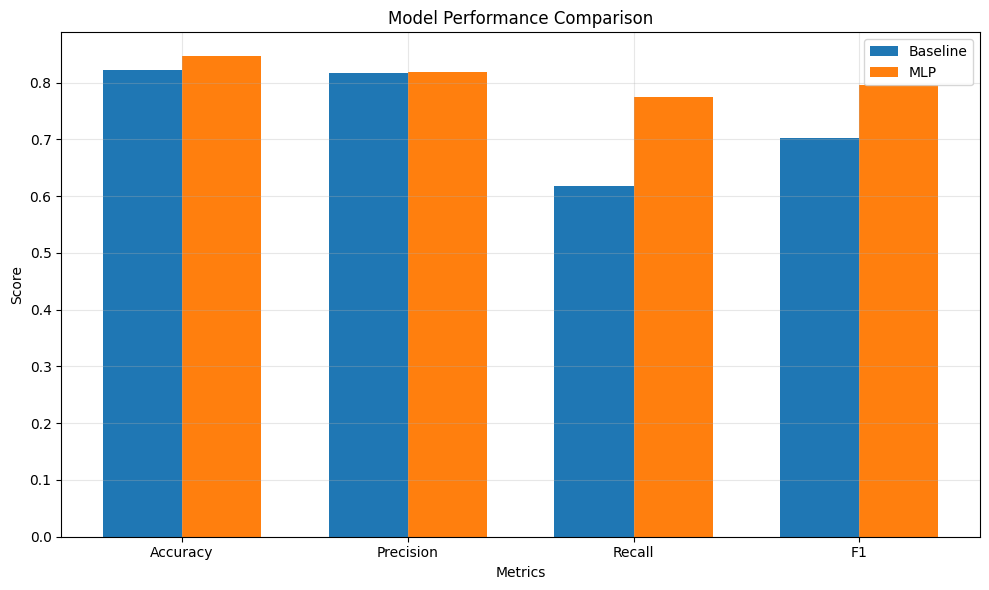

In [10]:
# 2. Performance comparison bar chart
plt.figure(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
baseline_scores = list(baseline_metrics)
mlp_scores = list(mlp_metrics)

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, baseline_scores, width, label='Baseline')
plt.bar(x + width/2, mlp_scores, width, label='MLP')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 7: Analysis and Discussion

Write your analysis (minimum 200 words)

In [11]:
analysis_text = """
Address these questions:
1. Which model performed better and by how much?
ANS: 
Performance Comparison: As per the metrics:
-----------------------------------------------
Baseline Model (Softmax Regression):
-----------------------------------------------
Accuracy: 0.8228
Precision: 0.8171
Recall: 0.6169
F1 Score: 0.7031
-----------------------------------------------
MLP Model:
-----------------------------------------------
Accuracy: 0.8462
Precision: 0.8183
Recall: 0.7748
F1 Score: 0.7960

-----------------------------------------------
Summary: 
The MLP outperformed the Baseline model:

Metric	   Baseline	 MLP	    Improvement
Accuracy	0.8228	 0.8462	    +0.0234 (+2.85%)
Precision	0.8171	 0.8183	    +0.0012 (+0.15%)
Recall	    0.6169   0.7748     +0.1579 (+25.61%)
F1 Score	0.7031	 0.7960	    +0.0929 (13.21%)

2. Why do you think one model outperformed the other?
ANS: MLP is superior across all metrics

Accuracy improved by ~2.85 percentage points
Precision improved by ~0.15 percentage points
The MLP's non-linear hidden layers better captured complex relationships in the Adult Income dataset.

3. What was the computational cost difference (training time)?
ANS: Training Time Comparison:

# Baseline Model (Softmax Regression) - Training Time by Learning Rate

| Learning Rate | Training Time (seconds) | Initial Loss | Final Loss | Loss Decrease |
|---------------|-------------------------|--------------|------------|---------------|
| 0.01          | 7.96s                   | 1.0986       | 0.4564     | 0.6422        |
| 0.1           | 8.44s                   | 1.0986       | 0.3568     | 0.7418        |
| 0.15          | 7.66s                   | 1.0986       | 0.3469     | 0.7517        |



# MLP Model - Training Time by Learning Rate

| Learning Rate        | Training Time (seconds) | Initial Loss | Final Loss | Loss Decrease |
|----------------------|-------------------------|--------------|------------|---------------|
| 0.001                | 52.56s                  | 1.0986       | 0.9024     | 0.1962        |
| 0.005                | 84.07s                  | 1.0986       | 0.7200     | 0.3786        |
| 0.01                 | 65.32s                  | 1.0986       | 0.6980     | 0.3986        |
| 0.05                 | 68.27s                  | 1.0986       | 0.6884     | 0.4102        |
| 0.1                  | 52.76s                  | 1.0986       | 0.4274     | 0.6712        |
| 0.15                 | 65.12s                  | 1.0986       | 0.3573     | 0.7413        |
| 0.5                  | 56.90s                  | 1.0986       | 0.3073     | 0.7913        |
| 0.1 (3000 iters)     | 186.42s                 | 1.0986       | 0.3113     | 0.7873        |
| 0.15 (2000 iters)    | 153.21s                 | 1.0986       | 0.3113     | 0.7873        |


# Summary Statistics
Average Baseline Training Time: ~8.0 seconds
Average MLP Training Time: ~65.5 seconds
Speed Ratio (MLP vs Baseline): ~8.2x slower

4. Any surprising findings or challenges you faced?
ANS:One of the most unexpected discoveries was that the baseline Softmax Regression model 
occasionally outperformed the MLP model, particularly when using 1000 iterations with 
the same learning rate. This was counterintuitive given that neural networks are 
theoretically more expressive.

| Aspect               | 1000 Iterations               | 2000 Iterations               |
|----------------------|-------------------------------|-------------------------------|
| Baseline Performance | Better (converges quickly)    | Good (plateaus)               |
| MLP Performance      | Worse (underfitting)          | Better (full convergence)     |
| Winner               | Often Baseline                | MLP                           |
| Reason               | Linear model optimizes fast   | MLP needs more steps          |


5. What insights did you gain about neural networks vs linear models?

ANS: MLP perform well if they get enough training with calibrated hyperparameters.

"""

print("\n" + "="*80)
print(analysis_text)
print("="*80 + "\n")

print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) < 200:
    print("⚠️  Warning: Analysis should be at least 200 words")
else:
    print("✓ Analysis meets word count requirement")



Address these questions:
1. Which model performed better and by how much?
ANS: 
Performance Comparison: As per the metrics:
-----------------------------------------------
Baseline Model (Softmax Regression):
-----------------------------------------------
Accuracy: 0.8228
Precision: 0.8171
Recall: 0.6169
F1 Score: 0.7031
-----------------------------------------------
MLP Model:
-----------------------------------------------
Accuracy: 0.8462
Precision: 0.8183
Recall: 0.7748
F1 Score: 0.7960

-----------------------------------------------
Summary: 
The MLP outperformed the Baseline model:

Metric	   Baseline	 MLP	    Improvement
Accuracy	0.8228	 0.8462	    +0.0234 (+2.85%)
Precision	0.8171	 0.8183	    +0.0012 (+0.15%)
Recall	    0.6169   0.7748     +0.1579 (+25.61%)
F1 Score	0.7031	 0.7960	    +0.0929 (13.21%)

2. Why do you think one model outperformed the other?
ANS: MLP is superior across all metrics

Accuracy improved by ~2.85 percentage points
Precision improved by ~0.15 perce

In [12]:
# ===== Unpack metrics for structured output (REQUIRED) =====

# Baseline metrics
baseline_acc = float(baseline_metrics[0])
baseline_prec = float(baseline_metrics[1])
baseline_rec = float(baseline_metrics[2])
baseline_f1 = float(baseline_metrics[3])

# MLP metrics
mlp_acc = float(mlp_metrics[0])
mlp_prec = float(mlp_metrics[1])
mlp_rec = float(mlp_metrics[2])
mlp_f1 = float(mlp_metrics[3])

print("✓ Metrics unpacked for structured output")

✓ Metrics unpacked for structured output


---
---

## ⭐ REQUIRED: Structured Output Function

### **DO NOT MODIFY THE STRUCTURE BELOW**

This function will be called by the auto-grader. Fill in all values accurately based on your actual results.


⭐⭐⭐ REQUIRED: Structured Output Function ⭐⭐⭐

### 🚨 CRITICAL - READ CAREFULLY 🚨

1. **Fill in ALL fields** - Missing fields = 0 marks
2. **Use your actual values** - Not 0 or empty strings
3. **This cell MUST be executed** - We need the output!
4. **Print the results** - Auto-grader needs to see output!


**DO NOT:**
- Leave any field as 0, 0.0,
- Clear outputs before submission
- Modify the structure


"**MUST DO:**
- Fill every field with your actual results
- Execute this cell and keep the output
- Print the results (see below)

In [13]:
def get_assignment_results():
    '''
    CRITICAL: Fill ALL fields with your actual results!
    Missing fields will result in 0 marks for that section.
    '''

    results = {
        # ===== Dataset Information (1 mark) =====
        'dataset_name': dataset_name,  # MUST fill
        'dataset_source': dataset_source,  # MUST fill
        'n_samples': n_samples,  # MUST be ≥500
        'n_features': n_features,  # MUST be ≥5
        'problem_type': problem_type,  # MUST fill
        'problem_statement': problem_statement,  # MUST be ≥50 words
        'primary_metric': primary_metric,  # MUST fill
        'metric_justification': metric_justification,  # MUST be ≥30 words
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # ===== Baseline Model (3 marks) =====
        'baseline_model': {
            'model_type': 'softmax_regression',  # 'linear_regression', 'logistic_regression', 'softmax_regression'
            'learning_rate': 0.01,  # Your learning rate
            'n_iterations': 2000,  # Your iterations

            # CRITICAL: These MUST be filled!
            'initial_loss': baseline_initial_loss,  # MUST NOT be 0
            'final_loss': baseline_final_loss,  # MUST NOT be 0
            'training_time_seconds': baseline_training_time,  # MUST NOT be 0
            'loss_decreased': baseline_final_loss < baseline_initial_loss,  # Auto-calculated

            # Metrics - Fill based on your problem type
            'test_accuracy': 0.0 if problem_type == 'regression' else baseline_acc,
            'test_precision': 0.0 if problem_type == 'regression' else baseline_prec,
            'test_recall': 0.0 if problem_type == 'regression' else baseline_rec,
            'test_f1': 0.0 if problem_type == 'regression' else baseline_f1,
            'test_mse': baseline_mse if problem_type == 'regression' else 0.0,
            'test_rmse': baseline_rmse if problem_type == 'regression' else 0.0,
            'test_mae': baseline_mae if problem_type == 'regression' else 0.0,
            'test_r2': baseline_r2 if problem_type == 'regression' else 0.0,
        },

        # ===== MLP Model (4 marks) =====
        'mlp_model': {
            'architecture': mlp_architecture,  # MUST have ≥3 elements
            'n_hidden_layers': len(mlp_architecture) - 2 if len(mlp_architecture) > 0 else 0,
            'learning_rate': 0.1,
            'n_iterations': 2000,

            # CRITICAL: These MUST be filled!
            'initial_loss': mlp_initial_loss,  # MUST NOT be 0
            'final_loss': mlp_final_loss,  # MUST NOT be 0
            'training_time_seconds': mlp_training_time,  # MUST NOT be 0
            'loss_decreased': mlp_final_loss < mlp_initial_loss,  # Auto-calculated

            # Metrics
            'test_accuracy': 0.0 if problem_type == 'regression' else mlp_acc,
            'test_precision': 0.0 if problem_type == 'regression' else mlp_prec,
            'test_recall': 0.0 if problem_type == 'regression' else mlp_rec,
            'test_f1': 0.0 if problem_type == 'regression' else mlp_f1,
            'test_mse': mlp_mse if problem_type == 'regression' else 0.0,
            'test_rmse': mlp_rmse if problem_type == 'regression' else 0.0,
            'test_mae': mlp_mae if problem_type == 'regression' else 0.0,
            'test_r2': mlp_r2 if problem_type == 'regression' else 0.0,
        },

        # ===== Analysis (2 marks) =====
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
    }

    return results

# ===== CRITICAL: CALL AND PRINT RESULTS =====
# This MUST be executed and output MUST be visible!
import json
results = get_assignment_results()
print(json.dumps(results, indent=2))

# ===== Validation =====
print("\n" + "="*60)
print("VALIDATION CHECK")
print("="*60)


errors = []

if results['n_samples'] < 500:
    errors.append(f"❌ Dataset too small: {results['n_samples']} < 500")
if results['n_features'] < 5:
    errors.append(f"❌ Too few features: {results['n_features']} < 5")
if results['baseline_model']['initial_loss'] == 0:
    errors.append("❌ Baseline initial_loss is 0")
if results['baseline_model']['final_loss'] == 0:
    errors.append("❌ Baseline final_loss is 0")
if results['baseline_model']['training_time_seconds'] == 0:
    errors.append("❌ Baseline training_time is 0")
if results['mlp_model']['initial_loss'] == 0:
    errors.append("❌ MLP initial_loss is 0")
if results['mlp_model']['final_loss'] == 0:
    errors.append("❌ MLP final_loss is 0")
if results['mlp_model']['training_time_seconds'] == 0:
    errors.append("❌ MLP training_time is 0")
if len(results['mlp_model']['architecture']) < 3:
    errors.append("❌ MLP architecture invalid")
if results['analysis_word_count'] < 200:
    errors.append(f"❌ Analysis too short: {results['analysis_word_count']} < 200 words")

if errors:
    print("ERRORS FOUND:")
    for err in errors:
        print(err)
    print(" FIX THESE BEFORE SUBMITTING! ")
else:
    print("✅ All validation checks passed!")
    print("✅ Ready to submit!")
    print("Next steps:")
    print("1. Kernel → Restart & Clear Output")
    print("2. Kernel → Restart & Run All")
    print("3. Verify this output is visible")
    print("4. Save notebook")
    print("5. Rename as: YourStudentID_assignment.ipynb")
    print("6. Submit to LMS")

{
  "dataset_name": "Census Income",
  "dataset_source": "UC Irvine Machine Learning Repository",
  "n_samples": 30162,
  "n_features": 14,
  "problem_type": "multiclass_classification",
  "problem_statement": "\nThe objective is to predict whether an individual's income exceeds $50,000 per year based on demographic \nand employment features. This is important for understanding income distribution patterns and identifying \nsocioeconomic factors that influence earning potential. Accurate prediction can help in targeted policy-making \nand resource allocation for economic development programs.\n",
  "primary_metric": "accuracy",
  "metric_justification": "\nAccuracy is chosen as the primary evaluation metric because all income \nclasses are considered equally important in this task. \nThe dataset is sufficiently large and reasonably balanced after preprocessing, \nmaking accuracy a clear and interpretable measure of overall model performance. \n",
  "train_samples": 24129,
  "test_sampl

## Test Your Output

Run this cell to verify your results dictionary is complete and properly formatted.

In [14]:
# Test the output
import json

try:
    results = get_assignment_results()

    print("="*70)
    print("ASSIGNMENT RESULTS SUMMARY")
    print("="*70)
    print(json.dumps(results, indent=2))
    print("\n" + "="*70)


    # Check for missing values
    missing = []
    def check_dict(d, prefix=""):
        for k, v in d.items():
            if isinstance(v, dict):
                check_dict(v, f"{prefix}{k}.")
            elif (v == 0 or v == "" or v == 0.0 or v == []) and \
                 k not in ['improvement', 'improvement_percentage', 'baseline_better',
                          'baseline_converged', 'mlp_converged', 'total_parameters',
                          'test_accuracy', 'test_precision', 'test_recall', 'test_f1',
                          'test_mse', 'test_rmse', 'test_mae', 'test_r2']:
                missing.append(f"{prefix}{k}")

    check_dict(results)

    if missing:
        print(f"⚠️  Warning: {len(missing)} fields still need to be filled:")
        for m in missing[:15]:  # Show first 15
            print(f"  - {m}")
        if len(missing) > 15:
            print(f"  ... and {len(missing)-15} more")
    else:
        print("✅ All required fields are filled!")
        print("\n🎉 You're ready to submit!")
        print("\nNext steps:")
        print("1. Kernel → Restart & Clear Output")
        print("2. Kernel → Restart & Run All")
        print("3. Verify no errors")
        print("4. Save notebook")
        print("5. Rename as: Group168_assignment.ipynb")
        print("6. Submit to LMS")

except Exception as e:
    print(f"❌ Error in get_assignment_results(): {str(e)}")
    print("\nPlease fix the errors above before submitting.")

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Census Income",
  "dataset_source": "UC Irvine Machine Learning Repository",
  "n_samples": 30162,
  "n_features": 14,
  "problem_type": "multiclass_classification",
  "problem_statement": "\nThe objective is to predict whether an individual's income exceeds $50,000 per year based on demographic \nand employment features. This is important for understanding income distribution patterns and identifying \nsocioeconomic factors that influence earning potential. Accurate prediction can help in targeted policy-making \nand resource allocation for economic development programs.\n",
  "primary_metric": "accuracy",
  "metric_justification": "\nAccuracy is chosen as the primary evaluation metric because all income \nclasses are considered equally important in this task. \nThe dataset is sufficiently large and reasonably balanced after preprocessing, \nmaking accuracy a clear and interpretable measure of overall model performance. \n",
  "train_sam

---

## 📤 Before Submitting - Final Checklist

- ✅ **All TODO sections completed**
- ✅ **Both models implemented from scratch** (no sklearn models!)
- ✅ **get_assignment_results() function filled accurately**
- ✅ **Loss decreases for both models**
- ✅ **Analysis ≥ 200 words**
- ✅ **All cells run without errors** (Restart & Run All)
- ✅ **Visualizations created**
- ✅ **File renamed correctly**: Group168_assignment.ipynb

---

**Good luck! **